In [1]:
import pdb
from functools import partial
from typing import Callable

import einops
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import optax
from jaxtyping import PRNGKeyArray, PyTreeDef
from tqdm import tqdm

from diffuse.mixture import init_mixture, sampler_mixtr
from diffuse.neural_networks import MLP
from diffuse.score_matching import score_match_loss
from diffuse.sde import SDE, LinearSchedule, SDEState
from diffuse.unet import UNet
from diffuse.conditional import generate_cond_sample, pmcmc, pmcmc_step
from diffuse.images import measure, SquareMask, restore
from diffuse.conditional import CondSDE

%load_ext autoreload
%autoreload 2

In [ ]:


data = jnp.load("dataset/mnist.npz")
key = jax.random.PRNGKey(0)
xs = data["X"]
batch_size = 2

xs = jax.random.permutation(key, xs, axis=0)
data = einops.rearrange(xs, "b h w -> b h w 1")
# plt.imshow(data[0], cmap='gray')
# plt.show()
dt = jnp.linspace(0, 2.0, 200)
dt = jnp.array([2.0 / 200] * batch_size)

beta = LinearSchedule(b_min=0.02, b_max=5.0, t0=0.0, T=2.0)
sde = SDE(beta)



  0%|          | 0/1500 [00:00<?, ?it/s]

In [66]:
nn_unet = UNet(dt, 64, upsampling="pixel_shuffle")
dict_param = nn_unet.init(key, jnp.ones((batch_size, 28, 28, 1)), jnp.ones((batch_size, )))
#init_params = nn_unet.init(key, data[:batch_size], dt)
array_param, array_to_dict = jax.flatten_util.ravel_pytree(dict_param)


In [3]:
nn_trained = jnp.load("ann_2999.npz", allow_pickle=True)
nn_params = nn_trained["params"].item()
array_param, array_to_dict = jax.flatten_util.ravel_pytree(nn_params)

# test other implementation
#nn_trained = jnp.load("mnist_lin_2999.npz", allow_pickle=True)
#nn_params = nn_trained["param"]
#nn_params = array_to_dict(nn_params)

In [4]:
data = jnp.load("dataset/mnist.npz")
key = jax.random.PRNGKey(0)
xs = data["X"]
tf = 2.0
batch_size = 256
n_epochs = 3000
n_t = 256
dt = tf / n_t


xs = jax.random.permutation(key, xs, axis=0)
data = einops.rearrange(xs, "b h w -> b h w 1")
nn_unet = UNet(dt, 64, upsampling="pixel_shuffle")

In [5]:
def nn_score(x, t):
    return nn_unet.apply(nn_params, x, t)

In [6]:
n_steps = 500
rng_key = jax.random.PRNGKey(0)

ts = jnp.array([tf])
dts = jnp.array([2.0 / n_steps] * (n_steps))

beta = LinearSchedule(b_min=0.02, b_max=5.0, t0=0.0, T=2.0)
sde = SDE(beta=beta)

init_samples = jax.random.normal(rng_key, data[0].shape)
state_f = SDEState(position=init_samples, t=ts)

revert_sde = partial(sde.reverso, score=nn_score, dts=dts)
state_0, state_Ts = revert_sde(rng_key, state_f)

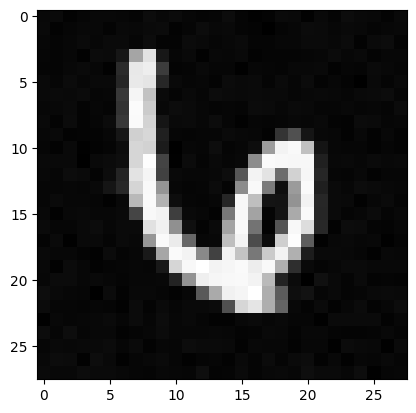

In [7]:
plt.imshow(state_Ts.position[-1], cmap="gray")
plt.show()

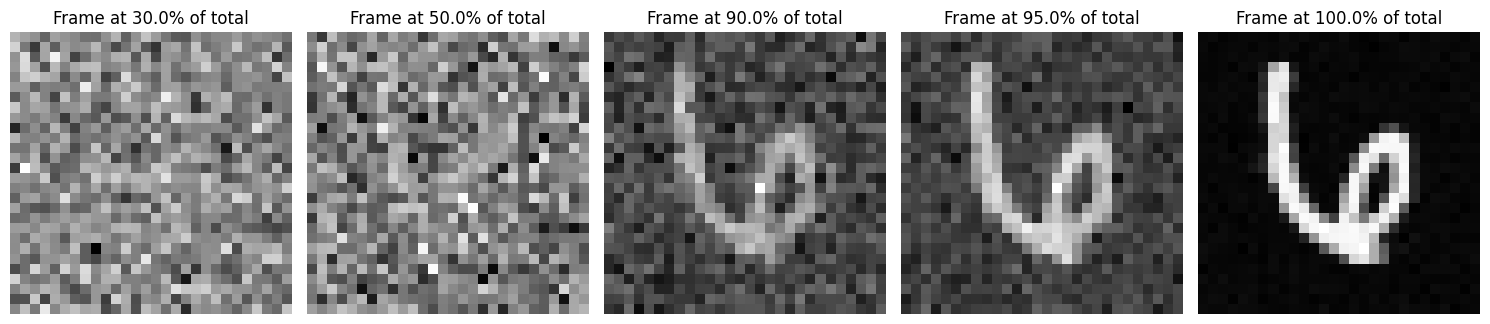

In [11]:
total_frames = len(state_Ts.position)

# Define the fractions
fractions = [0.3, 0.5, 0.9, .95, 1.]

# Create a figure with subplots
fig, axs = plt.subplots(1, 5, figsize=(15, 5))

for idx, fraction in enumerate(fractions):
    # Calculate the frame index
    frame_index = int(fraction * total_frames)
    
    # Plot the image
    axs[idx].imshow(state_Ts.position[frame_index], cmap="gray")
    axs[idx].set_title(f"Frame at {fraction*100}% of total")
    axs[idx].axis('off')  # Turn off axis labels

plt.tight_layout()
plt.show()

In [ ]:
mask = SquareMask(14, 14)
x = state_Ts.position[-1]
y = measure(x, mask)
cond_sde = CondSDE(score=nn_score, mask=mask)

generate_cond_sample(y, key, 100, cond_sde, x.shape)
